In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GaussianNoise, Flatten, Activation, Dropout, RepeatVector, Permute, Lambda, concatenate, dot, multiply
from tensorflow.keras.models import Model
from keras.layers import TimeDistributed
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import time

def normalize(data):
  min = np.min(data, axis = 0)
  max = np.max(data, axis = 0)
  #print('min, max',min, max)
  data = (data-min)/(max-min)
  return data

# Generate sample data
def generate_data(n_points, n_features, window_size, data = None):
    if data is None:
      data = np.random.randn(n_points, n_features)
    data = normalize(data)
    #data = np.random.normal(loc= 0.0, scale= 1.0 ,size = (n_points, n_features))
    X = []
    Y = []
    #print(data)
    for i in range(0, n_points-2*window_size+1):
      X.append(data[i:i+window_size,:])
      Y.append(data[i+window_size:i+2*window_size,:])
    return X, Y



In [32]:
#n_train = 30

In [33]:
# # Generate data
# n_points = 1000
# n_train = int((n_points-2*window_size)*0.9)  #80% training samples
# X, Y = generate_data(n_points, n_features, window_size)
# print(len(X), len(Y))

# X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
# X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
# print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_train: {y_test.shape}')


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, 4)]            0         []                            
                                                                                                  
 lstm_8 (LSTM)               [(None, None, 32),           4736      ['input_5[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                                  
 dense_8 (Dense)             (None, None, 1)              33        ['lstm_8[0][0]']              
                                                                                            

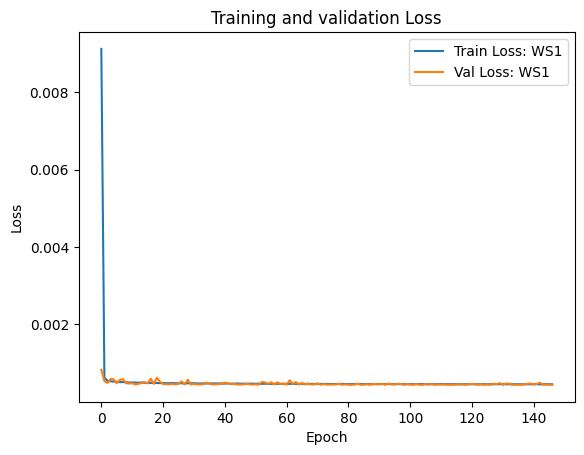

In [34]:
st = time.time()
# Parameters
win_size = [1]#[1,3,7,10] # input = ouput = window_size
bs = 32
ld = 32 #128 Latent dimension
eps = 1000 #1000

# Import simulated data
#data = pd.read_csv(r"../content/simulated_data2_non_linear_01212023.csv")
#data = pd.read_csv(r"../content/data_linear04_04022024.csv")
#data = pd.read_csv(r"../content/data_nonlinear01_04052024.csv")
#data = pd.read_csv(r"../content/data_nonlinear02_04052024.csv")
data = pd.read_csv(r"../content/Literaturedata_nonlinear04_04112024.csv")

data = data.to_numpy().T
n_features = data.shape[1]
n_points = data.shape[0]
R2 = []
for window_size in win_size:
  n_train = int((n_points-2*window_size)*0.9)  #80% training samples
  # Generate data
  X, Y = generate_data(n_points, n_features, window_size, data)
  #print(len(X), len(Y))

  X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
  X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
  #print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_test: {y_test.shape}')
  # X_test1,X_test2,X_test3 = X_test.copy(),X_test.copy(),X_test.copy()
  # X_test1[:,:,0] = 0 # To measure causality of variable x1 on other two variables
  # X_test2[:,:,1] = 0 # To measure causality of variable x2 on other two variables
  # X_test3[:,:,2] = 0 # To measure causality of variable x3 on other two variables
  # Define model
  latent_dim = ld #128(optimal)

  dropout_rate = 0.4  # Example dropout rate

  inputs = Input(shape=(None, n_features))
  # First LSTM layer in the encoder with return_sequences=True
  # encoded = LSTM(latent_dim, activation='selu', return_sequences=True, go_backwards=False)(inputs)
  # encoded = Dropout(dropout_rate)(encoded)  # Adding dropout after the first LSTM layer
  # Second LSTM layer in the encoder
  encoded, state_h, state_c = LSTM(latent_dim, activation='selu', return_sequences=True, return_state=True)(inputs)
  encoder_states = [state_h, state_c]

  # Compute importance for each step
  attention = Dense(1, activation='tanh')(encoded)
  attention = Flatten()(attention)
  attention = Activation('softmax', name='attention')(attention)
  attention = RepeatVector(latent_dim)(attention)
  attention = Permute([2, 1])(attention)

  encoded = multiply([encoded, attention])
  context = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(encoded)

  # Decoder
  decoder_input = Lambda(lambda x: tf.keras.backend.repeat(x[0], tf.shape(x[1])[1]))([context, inputs])
  # First LSTM layer in the decoder with return_sequences=True
  decoded = LSTM(latent_dim, activation='selu', return_state=False, return_sequences=True)(decoder_input, initial_state=encoder_states)
  # decoded = Dropout(dropout_rate)(decoded)  # Adding dropout after the first LSTM layer
  # Second LSTM layer in the decoder
  # decoded = LSTM(latent_dim, activation='selu', return_sequences=True)(decoded)

  # Experiment with this attention module
  attention = dot([decoded, encoded], axes=[2, 2])
  attention = Activation('softmax')(attention)
  attention = dot([attention, encoded], axes=[2,1])
  decoded = concatenate([attention, decoded])

  decoded = TimeDistributed(Dense(n_features), name='autoencoder')(decoded)

  # Define models
  encoder = Model(inputs, context)
  autoencoder = Model(inputs, decoded)
  autoencoder.summary()
  # Compile model
  autoencoder.compile(optimizer="adam", loss="mse")

  # Train model
  es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
  history = autoencoder.fit(X_train, y_train, epochs=eps, batch_size=bs, verbose=0, validation_split=0.1, callbacks = [es])

  # Plot training and validation loss
  plt.plot(history.history['loss'], label='Train Loss: WS'+str(window_size))
  plt.plot(history.history['val_loss'], label='Val Loss: WS'+str(window_size))
  plt.title('Training and validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  #plt.show()

  y_pred = autoencoder.predict(X_test)
  #print(y_pred.shape, y_pred)
  yy_pred = y_pred.reshape(-1,3)
  yy_test = y_test.reshape(-1,3)

  # mse = mean_squared_error(yy_test, yy_pred)
  # mae = mean_absolute_error(yy_test, yy_pred)
  # r2 = r2_score(yy_test, yy_pred)

  # print("mean Test MAE:", mae)
  # print("mean Test MSE:", mse)
  # print("mean Test RMSE:", np.sqrt(mse))
  # print("mean Test R-squared:", r2)

  mse = []
  mae = []
  rmse = []
  r2 = []
  for i in range(3):
    mse.append(mean_squared_error(yy_test[:,i], yy_pred[:,i]))  #self causal when i ==0
    mae.append(mean_absolute_error(yy_test[:,i], yy_pred[:,i]))
    rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred[:,i])))
    r2.append(r2_score(yy_test[:,i], yy_pred[:,i]))
  print('window_size:: ',window_size)
  print("Test MAE:", mae)
  print("Test MSE:", mse)
  print("Test MSE:", rmse)
  print("Test R-squared:", r2)
  R2.append(r2)
print([win_size, np.array(R2)])

et = time.time()
print(f'duration: {(et-st)/60} min')


In [35]:
# Rsq = np.array([[-1.46053206e-04, -1.98010903e-05, -5.75611767e-04],
#        [ 2.72949108e-01,  8.07942397e-01,  3.17864119e-01],
#        [ 1.95784889e-01,  7.46860123e-01,  2.93509010e-01],
#        [ 1.65461122e-01,  7.04435724e-01,  2.80179187e-01],
#        [ 1.35942224e-01,  6.40499075e-01,  2.53801891e-01]])

In [36]:
# np.mean(Rsq,axis = 1)

In [37]:
print(R2)
np.mean(R2, axis= 1)

[[0.9957909940324289, 0.9957750439338432, 0.9959508336914982]]


array([0.99583896])

In [38]:
R2max_ind = np.argmax(np.mean(R2, axis= 1))
print(R2max_ind)
best_winsize = win_size[R2max_ind]
print(best_winsize)


0
1


In [39]:
# best_winsize = 3
# data = pd.read_csv(r"../content/data_nonlinear03_04052024.csv")

# data = data.to_numpy().T
# n_points = data.shape[0]
# n_features = data.shape[1]

Epoch 1/1000
1519/1519 [==============================] - 11s 5ms/step - loss: 0.0098 - val_loss: 8.3813e-04
Epoch 2/1000
1519/1519 [==============================] - 6s 4ms/step - loss: 6.4000e-04 - val_loss: 6.3184e-04
Epoch 3/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 5.4324e-04 - val_loss: 5.5166e-04
Epoch 4/1000
1519/1519 [==============================] - 6s 4ms/step - loss: 5.2512e-04 - val_loss: 5.9961e-04
Epoch 5/1000
1519/1519 [==============================] - 8s 5ms/step - loss: 5.0619e-04 - val_loss: 4.8567e-04
Epoch 6/1000
1519/1519 [==============================] - 6s 4ms/step - loss: 5.1163e-04 - val_loss: 4.7678e-04
Epoch 7/1000
1519/1519 [==============================] - 8s 5ms/step - loss: 5.0436e-04 - val_loss: 5.3297e-04
Epoch 8/1000
1519/1519 [==============================] - 7s 4ms/step - loss: 5.0292e-04 - val_loss: 4.9448e-04
Epoch 9/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 4.9830e-04 - val_loss: 4.5488

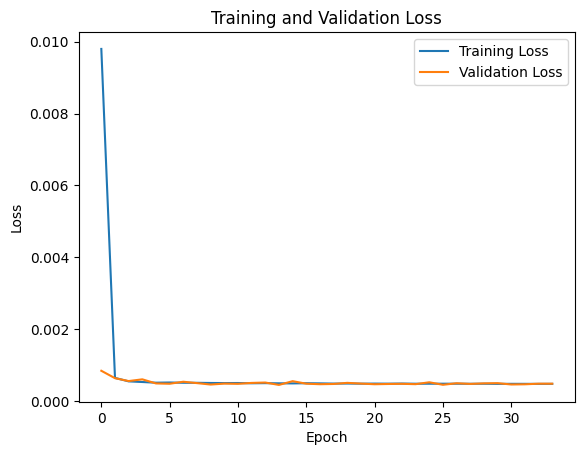

In [40]:

n_train = int((n_points-2*best_winsize)*0.9)  #80% training samples
# Generate data
X, Y = generate_data(n_points, n_features, best_winsize, data)
#print(len(X), len(Y))

X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
#print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_test: {y_test.shape}')
# X_test1,X_test2,X_test3 = X_test.copy(),X_test.copy(),X_test.copy()
# X_test1[:,:,0] = 0 # To measure causality of variable x1 on other two variables
# X_test2[:,:,1] = 0 # To measure causality of variable x2 on other two variables
# X_test3[:,:,2] = 0 # To measure causality of variable x3 on other two variables
# Define model
latent_dim = ld #128(optimal)

dropout_rate = 0.4  # Example dropout rate

inputs = Input(shape=(None, n_features))
# First LSTM layer in the encoder with return_sequences=True
# encoded = LSTM(latent_dim, activation='selu', return_sequences=True, go_backwards=False)(inputs)
# encoded = Dropout(dropout_rate)(encoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the encoder
encoded, state_h, state_c = LSTM(latent_dim, activation='selu', return_sequences=True, return_state=True)(inputs)
encoder_states = [state_h, state_c]

# Compute importance for each step
attention = Dense(1, activation='tanh')(encoded)
attention = Flatten()(attention)
attention = Activation('softmax', name='attention')(attention)
attention = RepeatVector(latent_dim)(attention)
attention = Permute([2, 1])(attention)

encoded = multiply([encoded, attention])
context = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(encoded)

# Decoder
decoder_input = Lambda(lambda x: tf.keras.backend.repeat(x[0], tf.shape(x[1])[1]))([context, inputs])
# First LSTM layer in the decoder with return_sequences=True
decoded = LSTM(latent_dim, activation='selu', return_state=False, return_sequences=True)(decoder_input, initial_state=encoder_states)
# decoded = Dropout(dropout_rate)(decoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the decoder
# decoded = LSTM(latent_dim, activation='selu', return_sequences=True)(decoded)

#Experiment with this attention module
attention = dot([decoded, encoded], axes=[2, 2])
attention = Activation('softmax')(attention)
attention = dot([attention, encoded], axes=[2,1])
decoded = concatenate([attention, decoded])

decoded = TimeDistributed(Dense(n_features), name='autoencoder')(decoded)

# Define models
encoder = Model(inputs, context)
autoencoder = Model(inputs, decoded)
#autoencoder.summary()
# Compile model
autoencoder.compile(optimizer="adam", loss="mse")

# Train model
es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
history = autoencoder.fit(X_train, y_train, epochs=eps, batch_size=bs, verbose=1, validation_split=0.1, callbacks = [es])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.show()

y_pred = autoencoder.predict(X_test)
#print(y_pred.shape, y_pred)
yy_pred = y_pred.reshape(-1,n_features)
yy_test = y_test.reshape(-1,n_features)

# mse = mean_squared_error(yy_test, yy_pred)
# mae = mean_absolute_error(yy_test, yy_pred)
# r2 = r2_score(yy_test, yy_pred)

# print("mean Test MAE:", mae)
# print("mean Test MSE:", mse)
# print("mean Test RMSE:", np.sqrt(mse))
# print("mean Test R-squared:", r2)

mse = []
mae = []
rmse = []
r2 = []
for i in range(n_features):
  mse.append(mean_squared_error(yy_test[:,i], yy_pred[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred[:,i]))
print('Best window_size:: ',best_winsize)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test MSE:", rmse)
print("Test R-squared:", r2)


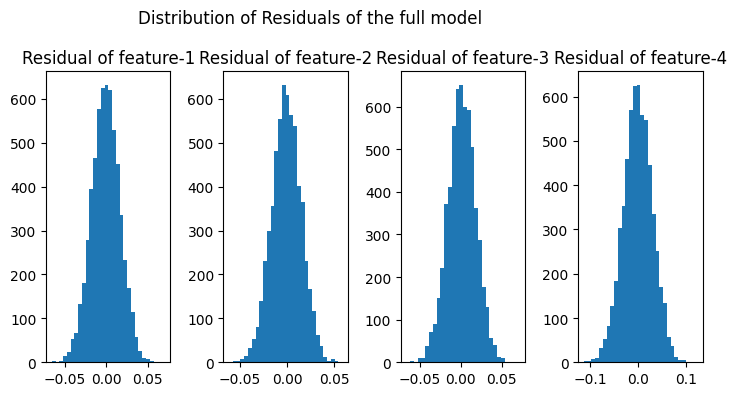

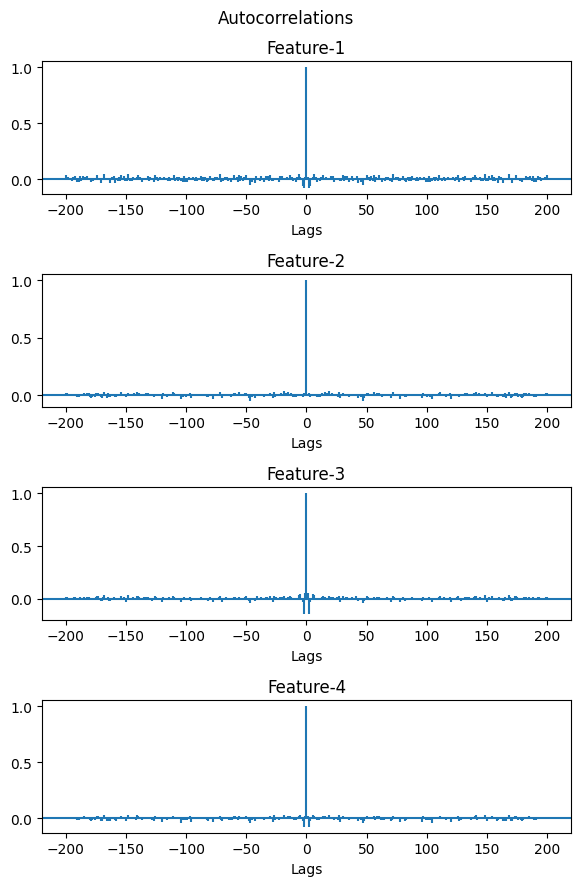

In [46]:
#Code for distribution of residual. See if they are normally distributed.
import seaborn as sns
plt.figure(figsize= (9,4))
plt.suptitle('Distribution of Residuals of the full model', x= 0.35)
for i in range(n_features):
  plt.subplot(1,n_features+1,i+1)
  residuals = yy_test[:,i]- yy_pred[:,i]
  plt.hist(residuals, bins = 30) #, bins = 5
  #sns.kdeplot(residuals, color='r', linewidth=2)
  plt.title('Residual of feature-'+str(i+1))
plt.tight_layout()
plt.show()
plt.close()

#Code for auto correlation of the residuals
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(6,9))
plt.suptitle('Autocorrelations')
for i in range(n_features):
  plt.subplot(n_features, 1, i+1)
  residuals =  yy_test[:,i]-yy_pred[:,i]
  # residuals = DataFrame(residuals)
  # autocorrelation_plot(residuals)
  plt.acorr(yy_test[:,i]-yy_pred[:,i], maxlags = 200)
  plt.title(f'Feature-{i+1}')
  plt.xlabel('Lags')
plt.tight_layout()
plt.show()
plt.close()

In [42]:
mse = []
mae = []
rmse = []
r2 = []
variance = []
for i in range(3):
  variance.append(np.var(yy_test[:,i]-yy_pred[:,i]))
  mse.append(mean_squared_error(yy_test[:,i], yy_pred[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred[:,i]))
print('variance: ',variance)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)

variance:  [0.0002889893251630529, 0.00024379177348207053, 0.0002889461413209575]
Test MAE: [0.013569546428625628, 0.012450747715675422, 0.013600497400083055]
Test MSE: [0.00029015541267297457, 0.00024412311515834855, 0.00029067632573061844]
Test RMSE: [0.01703394882794282, 0.015624439675020302, 0.017049232408839363]
Test R-squared: [0.9980649961244634, 0.9981523359799849, 0.9958409684654271]


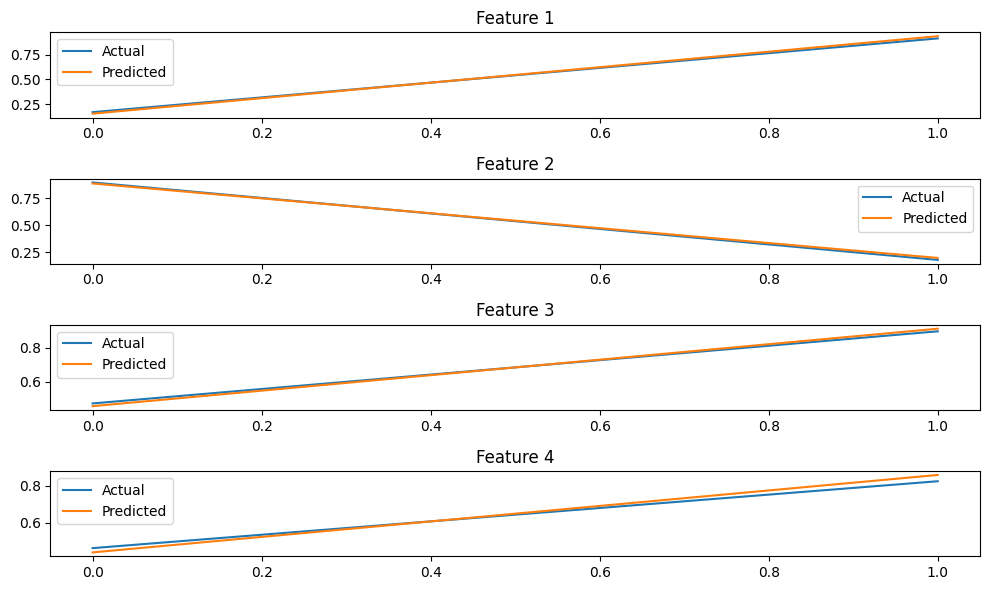

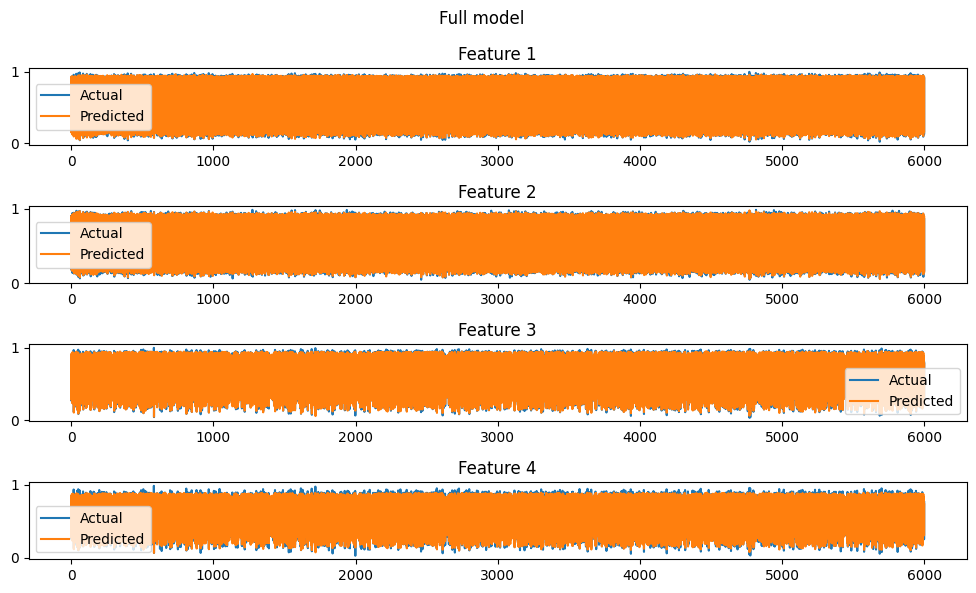

In [43]:
# Plotting of Actual and predicted (Full model) signal
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[0:2*best_winsize, i], label='Actual')
    plt.plot(yy_pred[0:2*best_winsize, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.suptitle('Full model')
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

188/188 [==============================] - 0s 2ms/step

Causal effect of feature 1 on other variables:
Causal effect for feature 1: [5.83838483 6.16073885 5.03460853 3.85356247]
188/188 [==============================] - 0s 2ms/step

Causal effect of feature 2 on other variables:
Causal effect for feature 2: [3.64266074 1.60858222 2.95895966 1.54699621]
188/188 [==============================] - 0s 2ms/step

Causal effect of feature 3 on other variables:
Causal effect for feature 3: [1.71102356 0.96359482 6.80618579 5.38219815]
188/188 [==============================] - 0s 2ms/step

Causal effect of feature 4 on other variables:
Causal effect for feature 4: [4.19648433 2.37852982 4.72100655 3.31068457]
Causality:  [[5.83838483 6.16073885 5.03460853 3.85356247]
 [3.64266074 1.60858222 2.95895966 1.54699621]
 [1.71102356 0.96359482 6.80618579 5.38219815]
 [4.19648433 2.37852982 4.72100655 3.31068457]]


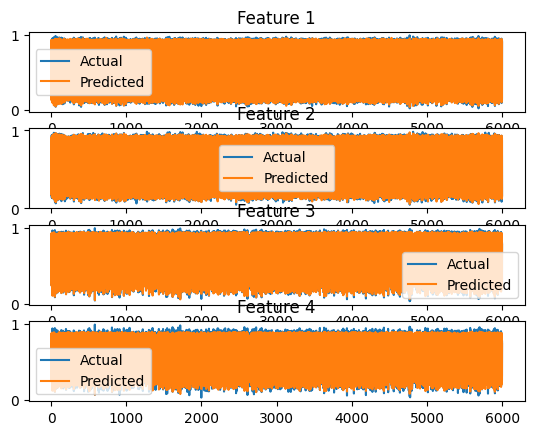

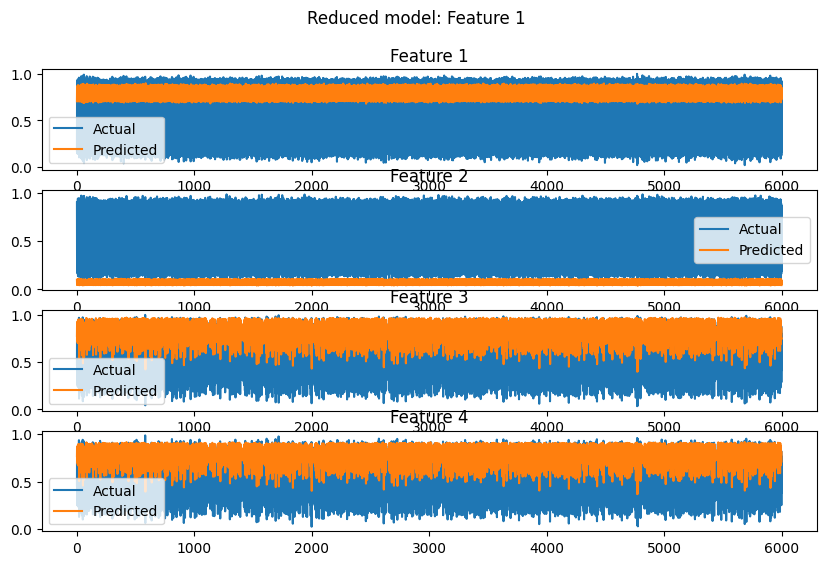

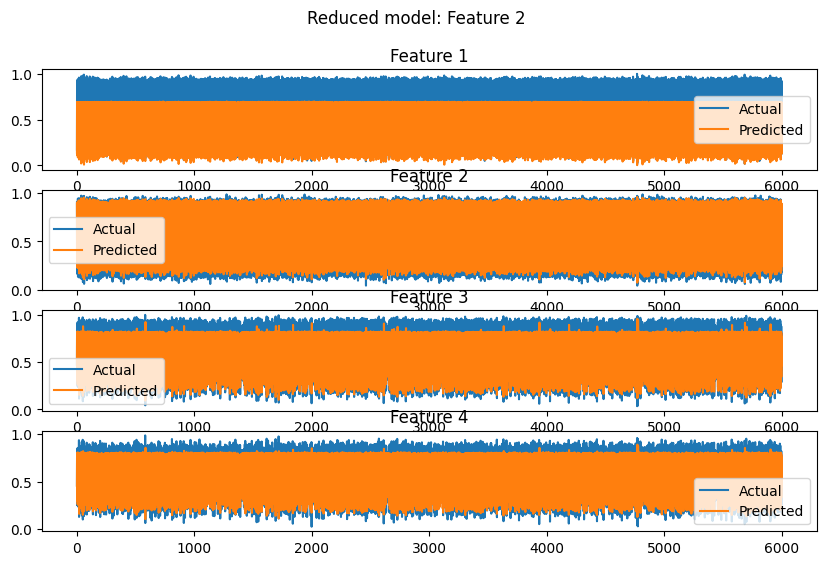

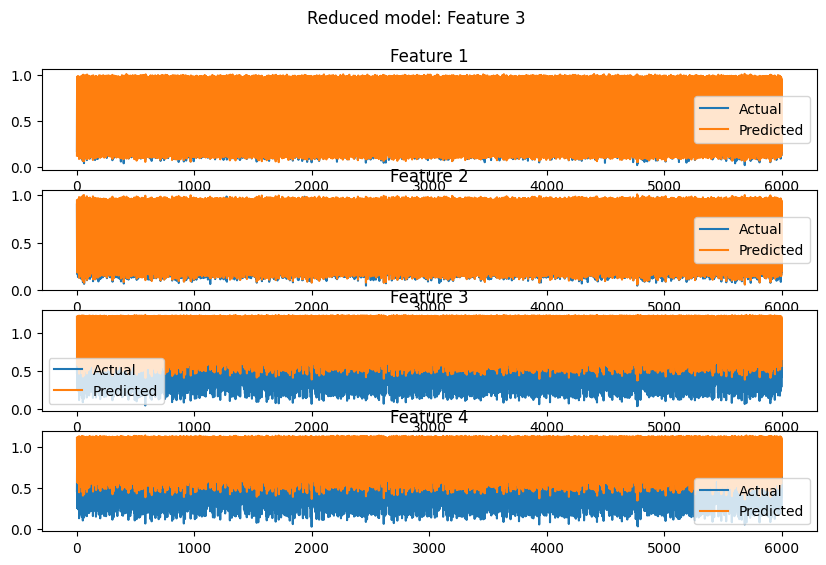

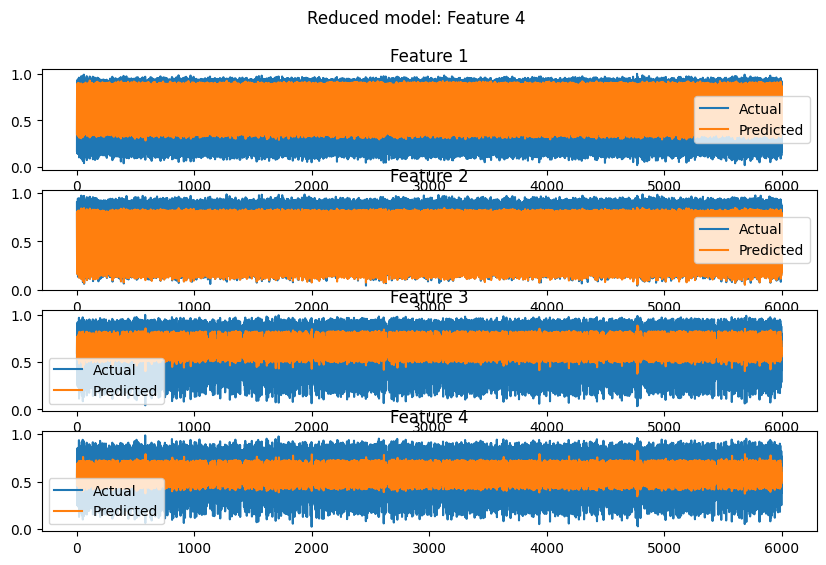

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def modify_feature(X, feature_index):
    X_modified = X.copy()
    X_modified[:, :, feature_index] = 0
    return X_modified

def calculate_metrics(y_test, y_pred, n_features):
    mse, mae, rmse, r2, variance = [], [], [], [], []
    yy_test = y_test.reshape(-1, n_features)
    yy_pred = y_pred.reshape(-1, n_features)

    for i in range(n_features):
        mse.append(mean_squared_error(yy_test[:, i], yy_pred[:, i]))
        mae.append(mean_absolute_error(yy_test[:, i], yy_pred[:, i]))
        rmse.append(np.sqrt(mse[-1]))
        r2.append(r2_score(yy_test[:, i], yy_pred[:, i]))
        variance.append(np.var(yy_test[:, i] - yy_pred[:, i]))

        plt.subplot(n_features, 1, i + 1)
        plt.plot(yy_test[:, i], label='Actual')
        plt.plot(yy_pred[:, i], label='Predicted')
        plt.title(f'Feature {i + 1}')
        plt.legend()

    # print("Test MAE:", mae)
    # print("Test MSE:", mse)
    # print("Test RMSE:", rmse)
    # print("Test R-squared:", r2)
    # print('Variance: ', variance)
    # plt.tight_layout()
    # plt.show()
    # plt.close()

    return variance
n_features = X_test.shape[2]
original_variance = []  # Store original variances here

# Calculate metrics for the unmodified test set
y_pred_original = autoencoder.predict(X_test)
original_variance = calculate_metrics(y_test, y_pred_original, n_features)

# Loop over all features
causality = []
for feature_index in range(n_features):
    X_test_modified = modify_feature(X_test, feature_index)
    y_pred_modified = autoencoder.predict(X_test_modified)
    print(f'\nCausal effect of feature {feature_index + 1} on other variables:')
    plt.figure(figsize=(10, 6))
    plt.suptitle(f'Reduced model: Feature {feature_index + 1}')

    modified_variance = calculate_metrics(y_test, y_pred_modified, n_features)

    causal_effect = np.log(np.array(modified_variance) / np.array(original_variance))
    print(f'Causal effect for feature {feature_index + 1}:', causal_effect)
    causality.append(causal_effect)
print('Causality: ',np.array(causality))

In [45]:
np.append(np.array(causality).flatten(), 1)

array([5.83838483, 6.16073885, 5.03460853, 3.85356247, 3.64266074,
       1.60858222, 2.95895966, 1.54699621, 1.71102356, 0.96359482,
       6.80618579, 5.38219815, 4.19648433, 2.37852982, 4.72100655,
       3.31068457, 1.        ])